#    DESAFÍO 2
##   Modelo de Regresión
###  Grupo 4: Florencia Accardo, Juan Mutis, Joaquín Fernández, Rodrigo Arias, Ignacio Nasso 

<a id="section_toc"></a> 
## Indice

<a href="#section_intro">PARTE INICIAL. IMPORTACIÓN DE LIBRERÍAS. IMPORTACIÓN DE DATA FINAL DESAFÍO 1</a>

<a href="#section_variables">NUEVAS VARIABLES</a>

<a href="#section_dummies">GENERAMOS DUMMIES</a>

<a href="#section_estandar">ESTANDARIZAMOS VARIABLES NUMÉRICAS</a>

<a href="#section_data">PREPARAMOS DATA FRAME A INGRESAR EN LOS MODELOS</a>

<a href="#section_reg_sts">REGRESIÓN LINEAL CON STASTMODEL</a>

<a href="#section_reg_skl">REGRESIÓN LINEAL CON SKLEARN</a>

<a href="#section_vif">EVALUAMOS VIF</a>

<a href="#section_lasso_cv">REGULARIZAMOS CON LASSO</a>

<a href="#section_ridge_cv">REGULARIZAMOS CON RIDGE</a>

<a href="#section_dec_tree">PROBAMOS DECISION TREE</a>

<a href="#section_ensemble">PROBAMOS MODELOS DE ENSEMBLE</a>

<a href="#section_gauss">EVALUAMOS PRINCIPIOS GAUSS-MARKOV</a>


---

<a id="section_intro"></a>
#### Importamos los datos del Desafío 1 y las librerías a utilizar

In [1]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.tools import eval_measures
from category_encoders import TargetEncoder
import re

In [2]:
data = pd.read_csv('data_final_Desafio_2.csv')
data.head()

,Unnamed: 0,property_type,state_name,Barrio_1,Barrio_2,Barrio_3,description_Clean,rooms_Clean,surface_total_in_m2_Clean,surface_covered_in_m2_Clean,price_clean,price_usd_per_m2_Clean
0,0,PH,Capital Federal,Mataderos,Sin definir,Sin definir,"2 ambientes tipo casa planta baja por pasillo,...",2.0,55.0,40.0,62000.0,1127.272727
1,1,apartment,Bs.As. G.B.A. Zona Sur,La Plata,Sin definir,Sin definir,venta de departamento en decimo piso al frente...,2.0,50.0,47.0,150000.0,3000.000000
2,2,apartment,Capital Federal,Mataderos,Sin definir,Sin definir,2 ambientes 3er piso lateral living comedor am...,2.0,55.0,55.0,72000.0,1309.090909
3,3,PH,Capital Federal,Liniers,Sin definir,Sin definir,ph 3 ambientes con patio. hay 3 deptos en lote...,3.0,83.0,65.0,95000.0,1144.578313
4,4,apartment,Bs.As. Costa Atlántica,Mar del Plata,Centro,Sin definir,departamento con fantastica iluminacion natura...,2.0,35.0,35.0,64000.0,1828.571429


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94387 entries, 0 to 94386
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   94387 non-null  int64  
 1   property_type                94387 non-null  object 
 2   state_name                   94387 non-null  object 
 3   Barrio_1                     94387 non-null  object 
 4   Barrio_2                     94387 non-null  object 
 5   Barrio_3                     94387 non-null  object 
 6   description_Clean            94385 non-null  object 
 7   rooms_Clean                  94387 non-null  float64
 8   surface_total_in_m2_Clean    94387 non-null  float64
 9   surface_covered_in_m2_Clean  94387 non-null  float64
 10  price_clean                  94387 non-null  float64
 11  price_usd_per_m2_Clean       94387 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 8.6+ MB


In [4]:
#sacamos 2 nulos que nos habían quedado en descr clean
data.loc[data.description_Clean.isna(),"description_Clean"] = ""

<a id="section_variables"></a>
#### Genramos nuevas variables para obtener mejores predicciones

##### Nuevas variables dicotómicas con las amenites que encontramos en description

In [5]:
amenities = ['balcon','toilette','suite', 'jardin', 'patio', 
             'dependencia', 'pileta', 'vigilancia', 'parrilla', 'ascensor', 'gimnasio', 'quincho', 'sauna', 'solarium', 'sala de juegos', 
             'laundry', 'sum', 'terraza', 'cochera', 'garage']

for i in amenities:
    data[i]= (data.description_Clean.str.contains(i)).astype(int)


##### Agregamos una columna que tenga el precio promedio por Property Type y state_name

In [6]:
#Creamos una serie que tenga la media de precio por 'property_type' y 'state_name'
grouped_by_price = data.groupby(['property_type','state_name', 'Barrio_1', 'Barrio_2' ])['price_clean'].transform('median').round(0)

data['precio_promedio'] = grouped_by_price
data.columns

Index(['Unnamed: 0', 'property_type', 'state_name', 'Barrio_1', 'Barrio_2',
       'Barrio_3', 'description_Clean', 'rooms_Clean',
       'surface_total_in_m2_Clean', 'surface_covered_in_m2_Clean',
       'price_clean', 'price_usd_per_m2_Clean', 'balcon', 'toilette', 'suite',
       'jardin', 'patio', 'dependencia', 'pileta', 'vigilancia', 'parrilla',
       'ascensor', 'gimnasio', 'quincho', 'sauna', 'solarium',
       'sala de juegos', 'laundry', 'sum', 'terraza', 'cochera', 'garage',
       'precio_promedio'],
      dtype='object')

##### Regex para ver la cantidad de baños

In [7]:
#extraccion de n de baños de la descripcion
banos_extract = data['description_Clean'].str.extract("([\d])(\s+)?(banos|bano|baño|baños)", re.IGNORECASE)

data["banos_Clean"] = banos_extract[0].str.replace(",","").replace(".","")

#eliminamos valores nulos
data["banos_Clean"] = data["banos_Clean"].apply(lambda x: x if x is not np.NaN else 0)

#convertimos a integer
data["banos_Clean"]=pd.to_numeric(data["banos_Clean"], errors="coerce", downcast="integer")

#reemplazamos donde banos son 0 y suponemos que tienen por lo menos 1
data.loc[data["banos_Clean"]==0,"banos_Clean"] = 1

#reemplazamos donde figura la palabra "banos" y solo figura 1, suponemos que tienen por lo menos 2
data.loc[(data["banos_Clean"]==1)&(data["description_Clean"].str.contains("banos")),"banos_Clean"] = 2

##### Generación de Target Encoder 

In [8]:
#usamos target encoder para Barrio_1 / Barrio_2 / Barrio_3 / State_name

for col in ['state_name', 'Barrio_1', 'Barrio_2']:
  encoder = TargetEncoder()
  data[col+"_Target"] = encoder.fit_transform(data[col], data['surface_covered_in_m2_Clean'])
    
   #For the case of continuous target: features are replaced with a blend of the expected value of the target given particular 
#categorical value and the expected value of the target over all the training data.


C:\Users\Joaquin\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\Joaquin\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\Joaquin\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf wi

In [9]:
data.columns

Index(['Unnamed: 0', 'property_type', 'state_name', 'Barrio_1', 'Barrio_2',
       'Barrio_3', 'description_Clean', 'rooms_Clean',
       'surface_total_in_m2_Clean', 'surface_covered_in_m2_Clean',
       'price_clean', 'price_usd_per_m2_Clean', 'balcon', 'toilette', 'suite',
       'jardin', 'patio', 'dependencia', 'pileta', 'vigilancia', 'parrilla',
       'ascensor', 'gimnasio', 'quincho', 'sauna', 'solarium',
       'sala de juegos', 'laundry', 'sum', 'terraza', 'cochera', 'garage',
       'precio_promedio', 'banos_Clean', 'state_name_Target',
       'Barrio_1_Target', 'Barrio_2_Target'],
      dtype='object')

In [10]:
data.shape

(94387, 37)

##### Dropeamos las columnas que no vamos a meter dentro del modelo, ya sea por el valor que aportan o para no tener data leakage

In [11]:
data.drop(["Unnamed: 0","description_Clean", 'price_clean', 'Barrio_3'],axis=1,inplace=True)

<a id="section_dummies"></a>
#### Generación de Dummies

In [12]:
#Creamos una lista con las variables categoricas a transformar en dummies

categoricals = ['property_type', 'state_name', 'Barrio_1', 'Barrio_2']

#generamos un dataframe sólo con las categoricals

X_cat = data[categoricals]

#instanciamos el OneHotEncoder
#no usamos el drop = First porque en el paso siguiente dropeamos arbitrariamente distintas dummies, por lo que no necesitamos que 

enc = preprocessing.OneHotEncoder()

#fiteamos con X_cat (esto lo que hace es aprender todas las categorías posibles)

enc.fit(X_cat)

#listamos las categorías
enc.categories_


#generamos el dataframe de dummies

dummies = enc.transform(X_cat).toarray()
dummies_df = pd.DataFrame(dummies)

#Generamos los nombres de las columnas

col_names = [categoricals[i] + '_' + enc.categories_[i] for i in range(len(categoricals)) ]

#dropeamos los primeros nombres de las columnas, porque es lo que hicimos cuando instanciamos el OneHotEncoder

#col_names_drop_first = [sublist[i] for sublist in col_names for i in range(len(sublist)) if i != 0]

col_names_sin_drop = [sublist[i] for sublist in col_names for i in range(len(sublist))]


#renombramos las columnas en el dataframe de dummies

#dummies_df.columns = col_names_drop_first
dummies_df.columns = col_names_sin_drop


dummies_df.head()

,property_type_PH,property_type_apartment,property_type_house,property_type_store,state_name_Bs.As. Costa Atlántica,state_name_Bs.As. G.B.A. Zona Norte,state_name_Bs.As. G.B.A. Zona Oeste,state_name_Bs.As. G.B.A. Zona Sur,state_name_Bs.As. Interior,state_name_Capital Federal,...,Barrio_2_Villa Vatteone,Barrio_2_Villa de Mayo,Barrio_2_Village Golf & Tennis Country Club,Barrio_2_Villars,Barrio_2_Virrey del Pino,Barrio_2_Virreyes,Barrio_2_Wilde,Barrio_2_William Morris,Barrio_2_Zelaya,Barrio_2_Zárate
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#Dropeamos arbitrariamente las dummies que tienen valores True por menos de 500 registros. Entendemos que si menos del 0.5%
# de los datos cuentan con esa característica, no nos proporciona info útil

columnas_dummies = dummies_df.columns
for i in columnas_dummies:
    if dummies_df[i].sum() < 500:
        dummies_df.drop(i, axis = 1, inplace = True)



<a id="section_estandar"></a>
#### Estandarizamos las variables numéricas

In [14]:

#listamos todas las variables numericas
numericas = ['surface_total_in_m2_Clean', 'surface_covered_in_m2_Clean', 'precio_promedio','rooms_Clean', 'banos_Clean', 'state_name_Target','Barrio_1_Target', 'Barrio_2_Target']

#instanciamos el scaler

#scaler_std = preprocessing.StandardScaler()
min_max_scaler = preprocessing.MinMaxScaler()
#generamos el dataframe a estandarizar

X_num = data[numericas]

#fiteamos con el scaler

min_max_scaler.fit(X_num)

#transoformamos y generamos el data frame con los valores estandarizados

X_scal = min_max_scaler.transform(X_num)
X_scal_df = pd.DataFrame(X_scal)

#renombramos las columnas del DF con el agregado de 'std' para identificarlas
X_scal_df.columns = [i + '_std' for i in numericas]
X_scal_df

,surface_total_in_m2_Clean_std,surface_covered_in_m2_Clean_std,precio_promedio_std,rooms_Clean_std,banos_Clean_std,state_name_Target_std,Barrio_1_Target_std,Barrio_2_Target_std
0,0.063776,0.046512,0.312915,0.285714,0.000,0.072543,0.278241,0.173791
1,0.051020,0.079070,0.223174,0.285714,0.000,0.364195,0.308056,0.173791
2,0.063776,0.116279,0.242805,0.285714,0.000,0.072543,0.278241,0.173791
3,0.135204,0.162791,0.366199,0.428571,0.000,0.072543,0.139939,0.173791
4,0.012755,0.023256,0.245329,0.285714,0.000,0.164728,0.167420,0.092333
...,...,...,...,...,...,...,...,...
94382,0.446429,0.813953,0.509225,0.285714,0.125,0.376435,0.344151,0.280505
94383,0.237245,0.432558,0.284871,0.285714,0.125,0.376435,0.344151,0.173791
94384,0.040816,0.041860,0.312915,0.142857,0.000,0.072543,0.069905,0.173791
94385,0.045918,0.083721,0.197432,0.285714,0.000,0.164728,0.167420,0.028328


<a id="section_data"></a>
#### Preparamos el dataframe que va a entrar al modelo

##### Unimos data, dummies y normalizadas

In [15]:
#unimos data a dummies_df, X_scal_df y dropeamos lo que no necesitamos mas en data 

data = pd.concat([data, X_scal_df, dummies_df], axis = 1)

data.drop(['property_type', 'surface_total_in_m2_Clean', 'surface_covered_in_m2_Clean', 
          'precio_promedio', 'state_name', 'Barrio_1', 'Barrio_2', 'rooms_Clean', 'banos_Clean'], axis=1, inplace = True)

data.head()

,price_usd_per_m2_Clean,balcon,toilette,suite,jardin,patio,dependencia,pileta,vigilancia,parrilla,...,Barrio_2_Lomas de Zamora,Barrio_2_Martínez,Barrio_2_Morón,Barrio_2_Nordelta,Barrio_2_Olivos,Barrio_2_Ramos Mejía,Barrio_2_Sin definir,Barrio_2_Temperley,Barrio_2_Tigre,Barrio_2_Villa Ballester
0,1127.272727,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,3000.000000,1,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1309.090909,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1144.578313,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1828.571429,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Train Test Split

In [16]:
col_feature = ['balcon', 'toilette', 'suite', 'jardin',
       'patio', 'dependencia', 'pileta', 'vigilancia', 'parrilla', 'ascensor',
       'gimnasio', 'quincho', 'sauna', 'solarium', 'sala de juegos', 'laundry',
       'sum', 'terraza', 'cochera', 'garage', 'surface_total_in_m2_Clean_std',
       'surface_covered_in_m2_Clean_std', 'precio_promedio_std',
       'rooms_Clean_std', 'banos_Clean_std', 'property_type_PH',
       'property_type_apartment', 'property_type_house', 'property_type_store',
       'state_name_Bs.As. Costa Atlántica',
       'state_name_Bs.As. G.B.A. Zona Norte',
       'state_name_Bs.As. G.B.A. Zona Oeste',
       'state_name_Bs.As. G.B.A. Zona Sur', 'state_name_Bs.As. Interior',
       'state_name_Capital Federal', 'state_name_Córdoba',
       'state_name_Mendoza', 'state_name_Neuquén', 'state_name_Río Negro',
       'state_name_Santa Fe', 'state_name_Tucumán', 'Barrio_1_Almagro',
       'Barrio_1_Almirante Brown', 'Barrio_1_Avellaneda', 'Barrio_1_Balvanera',
       'Barrio_1_Barrio Norte', 'Barrio_1_Belgrano', 'Barrio_1_Caballito',
       'Barrio_1_Córdoba', 'Barrio_1_Escobar', 'Barrio_1_Flores',
       'Barrio_1_General San Martín', 'Barrio_1_Ituzaingó',
       'Barrio_1_La Matanza', 'Barrio_1_La Plata', 'Barrio_1_Lanús',
       'Barrio_1_Lomas de Zamora', 'Barrio_1_Mar del Plata', 'Barrio_1_Morón',
       'Barrio_1_Nuñez', 'Barrio_1_Palermo', 'Barrio_1_Pilar',
       'Barrio_1_Pinamar', 'Barrio_1_Quilmes', 'Barrio_1_Recoleta',
       'Barrio_1_Rosario', 'Barrio_1_San Fernando', 'Barrio_1_San Isidro',
       'Barrio_1_San Miguel', 'Barrio_1_San Telmo', 'Barrio_1_Santa Fe',
       'Barrio_1_Sin definir', 'Barrio_1_Tigre', 'Barrio_1_Tres de Febrero',
       'Barrio_1_Vicente López', 'Barrio_1_Villa Crespo',
       'Barrio_1_Villa Urquiza', 'Barrio_2_Adrogué', 'Barrio_2_Banfield',
       'Barrio_2_Castelar', 'Barrio_2_La Plata', 'Barrio_2_Lanús',
       'Barrio_2_Lomas de Zamora', 'Barrio_2_Martínez', 'Barrio_2_Morón',
       'Barrio_2_Nordelta', 'Barrio_2_Olivos', 'Barrio_2_Ramos Mejía',
       'Barrio_2_Sin definir', 'Barrio_2_Temperley', 'Barrio_2_Tigre',
       'Barrio_2_Villa Ballester', 'state_name_Target','Barrio_1_Target', 'Barrio_2_Target']

col_target = "price_usd_per_m2_Clean"

X = data[col_feature]

y = data[col_target]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1234)

<a id="section_reg_sts"></a>
#### LinearRegression con StatsModel

In [18]:
#sumamos la constante a las features de train y test 

X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

#instanciamos y fiteamos el modelo en el mismo paso

linereg_sm = sm.OLS(y_train, X_train_sm).fit()

#Vemos el summary

linereg_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     price_usd_per_m2_Clean   R-squared:                       0.623
Model:                                OLS   Adj. R-squared:                  0.622
Method:                     Least Squares   F-statistic:                     1241.
Date:                    Fri, 25 Nov 2022   Prob (F-statistic):               0.00
Time:                            23:14:28   Log-Likelihood:            -5.4013e+05
No. Observations:                   70790   AIC:                         1.080e+06
Df Residuals:                       70695   BIC:                         1.081e+06
Df Model:                              94                                         
Covariance Type:                nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                1095.3440     69.282     15.810      0.000     959.552    1231.136
balcon                                 27.2652      4.411      6.182      0.000      18.620      35.910
toilette                               42.4645      6.189      6.861      0.000      30.333      54.596
suite                                 105.4556      6.327     16.668      0.000      93.055     117.856
jardin                                 -1.6803      6.584     -0.255      0.799     -14.584      11.224
patio                                -120.3065      5.396    -22.295      0.000    -130.883    -109.730
dependencia                           -42.8695      8.421     -5.091      0.000     -59.375     -26.364
pileta                                 37.6845      6.569      5.737      0.000      24.810      50.559
vigilancia                             30.0461     14.739      2.038      0.042       1.157      58.935
parrilla                                4.0795      5.426      0.752      0.452      -6.556      14.715
ascensor                               17.6321      7.309      2.412      0.016       3.307      31.957
gimnasio                               -3.5225      9.825     -0.359      0.720     -22.780      15.735
quincho                                23.7331      7.429      3.195      0.001       9.172      38.294
sauna                                  42.5103     13.988      3.039      0.002      15.094      69.927
solarium                               85.9554      7.468     11.510      0.000      71.318     100.593
sala de juegos                         80.6676     26.698      3.021      0.003      28.339     132.996
laundry                                72.1469      9.369      7.701      0.000      53.783      90.510
sum                                    23.3987      6.648      3.520      0.000      10.369      36.428
terraza                               -21.7701      4.877     -4.464      0.000     -31.328     -12.212
cochera                               118.7672      4.353     27.286      0.000     110.236     127.298
garage                                 32.1470      9.087      3.538      0.000      14.336      49.958
surface_total_in_m2_Clean_std       -2097.2091     17.761   -118.079      0.000   -2132.021   -2062.397
surface_covered_in_m2_Clean_std       -17.4006     16.745     -1.039      0.299     -50.220      15.419
precio_promedio_std                  1478.8196     26.851     55.076      0.000    1426.192    1531.447
rooms_Clean_std                       244.8413     17.110     14.310      0.000     211.306     278.377
banos_Clean_std                       111.4640     39.206      2.843      0.004      34.621     188.307
property_type_PH       

In [19]:
#vemos las predecimos y evaluamos en train 

sm_prediction_train = linereg_sm.predict(X_train_sm)
print(eval_measures.rmse(y_train, sm_prediction_train))


sm_prediction_test = linereg_sm.predict(X_test_sm)
print(eval_measures.rmse(y_test, sm_prediction_test))



498.2409627904018
500.75528616723074


<a id="section_reg_skl"></a>
#### LinearRegression Multiple con Sklearn

In [20]:
def regLinMul_function(dataset, col_feature, col_target):
 
    reg = linear_model.LinearRegression()

    # Entrenamos el modelo 

    reg.fit(X_train, y_train)

    #realizamos predicciones con el set de testeo
    y_pred= reg.predict(X_test)
    
    
    #vemos los Betas

    # print (reg.intercept_)
    # print (reg.coef_)

    # print(list(zip(X.columns, reg.coef_)))

    #evaluamos el r2 en Train 

    print ('R2 en Train:', reg.score(X_train, y_train))
    
    # evaluamos el r2 en Train ajustado por la cantidad de datos y la cantidad de features
    r2_train = reg.score(X_train, y_train)
    n = data.shape[0]
    p = len(col_feature)
    #evaluamos el r2 en Test
    print ('R2 en Test:', reg.score(X_test, y_test))
    print ('MAE:', metrics.mean_absolute_error(y_test,y_pred))
    print ('MSE:', metrics.mean_squared_error(y_test,y_pred))
regLin = regLinMul_function(data,X,y)

R2 en Train: 0.6225803280182237
R2 en Test: 0.6178966754231774
MAE: 379.95584305334336
MSE: 250755.75214774412


<a id="section_vif"></a>
#### Evaluamos el VIF

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = data[col_feature]
y = data[col_target]


series_vif =  pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])], index=X.columns)

series_vif.sort_values(ascending=False).head(20)

property_type_apartment                1421.098246
property_type_house                     519.643779
property_type_PH                        124.625127
state_name_Capital Federal               66.162772
property_type_store                      55.099629
state_name_Target                        43.229703
state_name_Bs.As. G.B.A. Zona Norte      37.046366
state_name_Santa Fe                      36.065737
state_name_Bs.As. Costa Atlántica        22.974999
state_name_Bs.As. G.B.A. Zona Sur        15.252549
state_name_Córdoba                       14.529077
Barrio_1_Tigre                           14.258381
Barrio_1_Rosario                         12.342373
state_name_Bs.As. G.B.A. Zona Oeste      11.633057
Barrio_1_Lomas de Zamora                  9.000302
Barrio_1_Vicente López                    7.878070
Barrio_1_Mar del Plata                    7.043194
Barrio_1_Target                           6.063526
Barrio_1_San Isidro                       5.484399
Barrio_1_Pilar                 

<a id="section_lasso_cv"></a>
#### Lasso con Cross Validation

In [22]:
#instanciamos el modelo y le metemos varios alphas para que pruebe 

lassoCV = linear_model.LassoCV(alphas = np.arange(0.001, 1, 0.005), cv = 3, normalize = False)

#fiteamos con train

lasso_cv_model = lassoCV.fit(X_train, y_train)

#el mejor alpha que encontró con Cross Validation 

print('Best alpha', lasso_cv_model.alpha_)
best_alpha_lasso = lasso_cv_model.alpha_

#Vemos Beta 0 y los coeficientes 

#print(lasso_cv_model.intercept_)
#print(lasso_cv_model.coef_)

#realizamos predicciones con el set de testeo
y_pred= lassoCV.predict(X_test)

#Observamos las metricas
print("R2 Train",lasso_cv_model.score(X_train, y_train))
print('R2 Test:', lasso_cv_model.score(X_test, y_test))
print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test,y_pred))

C:\Users\Joaquin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Best alpha 0.036000000000000004
R2 Train 0.6225613072624531
R2 Test: 0.6178581996382324
MAE: 379.95590340880455
MSE: 250781.00192646318


<a id="section_ridge_cv"></a>
#### Ridge con Cross Validation

In [23]:
#instanciamos el modelo y le metemos varios alphas para que pruebe 

ridgeCV = linear_model.RidgeCV(alphas = np.arange(1, 5, 0.01), normalize = False)

#fiteamos con train

ridge_cv_model = ridgeCV.fit(X_train, y_train)

#el mejor alpha que encontró con Cross Validation 

print('Best alpha', ridge_cv_model.alpha_)
#best_alpha_ridge = ridge_cv_model.alpha_

#Vemos Beta 0 y los coeficientes 

#ridge_cv_model.intercept_
#ridge_cv_model.coef_

#realizamos predicciones con el set de testeo
y_pred= ridge_cv_model.predict(X_test)

#Observamos las metricas
print("R2 Train",ridge_cv_model.score(X_train, y_train))
print('R2 Test:', ridge_cv_model.score(X_test, y_test))
print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test,y_pred))

C:\Users\Joaquin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Best alpha 3.6300000000000026
R2 Train 0.6225766202651051
R2 Test: 0.6178879705108371
MAE: 379.94271413569146
MSE: 250761.46475661427


<a id="section_dec_tree"></a>
#### Probamos con DecisionTreeRegressor

In [24]:
from sklearn import tree
reg_tree = tree.DecisionTreeRegressor(random_state=1234)
reg_tree.fit(X_train,y_train)
#Observamos features mas importantes
sorted(list(zip(X.columns,reg_tree.feature_importances_)),key=lambda x: x[1], reverse=True)[:5]
#realizamos predicciones con el set de testeo
y_pred= reg_tree.predict(X_test)

#Observamos las metricas
print("R2 Train",reg_tree.score(X_train, y_train))
print('R2 Test:', reg_tree.score(X_test, y_test))
print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test,y_pred))

R2 Train 0.9625813769032743
R2 Test: 0.5685645993389622
MAE: 346.359070163742
MSE: 283129.98458135925


<a id="section_ensemble"></a>
### Ensemble

##### HistGradientBoostingRegressor

In [25]:
from sklearn.ensemble import HistGradientBoostingRegressor
HGBreg=HistGradientBoostingRegressor(random_state=1234)
HGBreg.fit(X_train,y_train)

#realizamos predicciones con el set de testeo
y_pred= HGBreg.predict(X_test)

#Observamos las metricas
print("R2 Train",HGBreg.score(X_train, y_train))
print('R2 Test:', HGBreg.score(X_test, y_test))
print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test,y_pred))

R2 Train 0.7211449465829822
R2 Test: 0.7024056876867424
MAE: 325.80132967533723
MSE: 195296.61434285267


##### RandomForestRegressor

In [26]:
from sklearn.ensemble import RandomForestRegressor
RFreg=RandomForestRegressor(random_state=1234,n_estimators=100,max_depth=10)
RFreg.fit(X_train,y_train) 

#realizamos predicciones con el set de testeo
y_pred= RFreg.predict(X_test)

#Observamos las metricas
print("R2 Train",RFreg.score(X_train, y_train))
print('R2 Test:', RFreg.score(X_test, y_test))
print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test,y_pred))

R2 Train 0.7286259101458983
R2 Test: 0.6924791875361955
MAE: 331.3030104512172
MSE: 201810.8916373561


<a id="section_gauss"></a>

#### Supuestos de GAUSS MARKOV

##### Linealidad del modelo

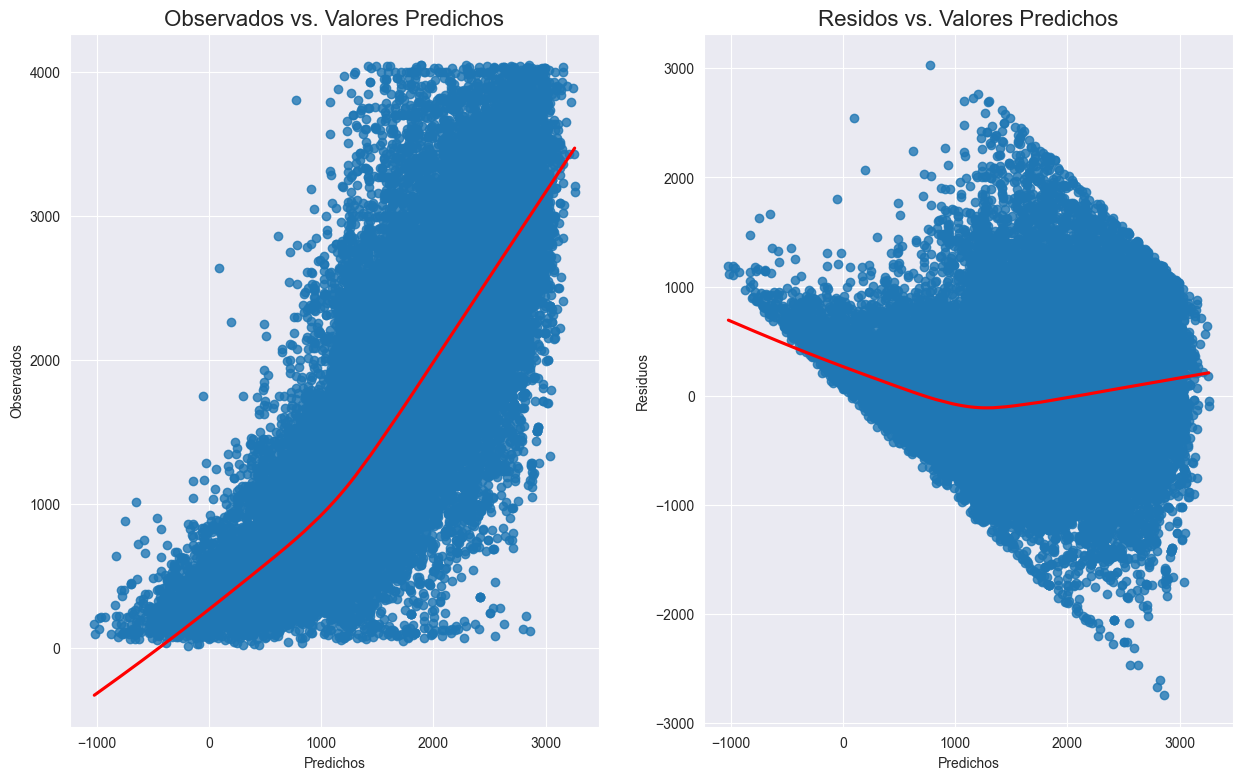

In [27]:
%matplotlib inline
#%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def linearity_test(model, y):
    '''
    funcion para visualizar e identificar supuestos de linealidad sobre la regression lineal
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observados vs. Valores Predichos', fontsize=16)
    ax[0].set(xlabel='Predichos', ylabel='Observados')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residos vs. Valores Predichos', fontsize=16)
    ax[1].set(xlabel='Predichos', ylabel='Residuos')
    
linearity_test(linereg_sm, y_train)    

Observar que el patrón inclinado en la grafica de los residuos puede deberse a que el modelo contiene muchas características

##### Esperanza de los residuos igual a cero.

In [28]:
linereg_sm.resid.mean()

-3.239466211250596e-11

##### Multicolinealidad

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns).T

C:\Users\Joaquin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\Joaquin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,balcon,toilette,suite,jardin,patio,dependencia,pileta,vigilancia,parrilla,ascensor,...,Barrio_2_Nordelta,Barrio_2_Olivos,Barrio_2_Ramos Mejía,Barrio_2_Sin definir,Barrio_2_Temperley,Barrio_2_Tigre,Barrio_2_Villa Ballester,state_name_Target,Barrio_1_Target,Barrio_2_Target
vif,1.315838,1.238608,1.365801,1.204274,1.264241,1.104397,1.21668,1.062216,1.51985,1.132024,...,2.608607,1.74923,1.840048,4.15452,2.320495,1.679186,1.578117,43.507114,6.075418,2.227617


##### Homocedasticidad 


 Breusch-Pagan test ----
                                     value
Lagrange multiplier statistic  3971.666546
p-value                           0.000000
f-value                          44.703135
f p-value                         0.000000

 Goldfeld-Quandt test ----
                value
F statistic  1.013953
p-value      0.096517

 Residuals plots ----


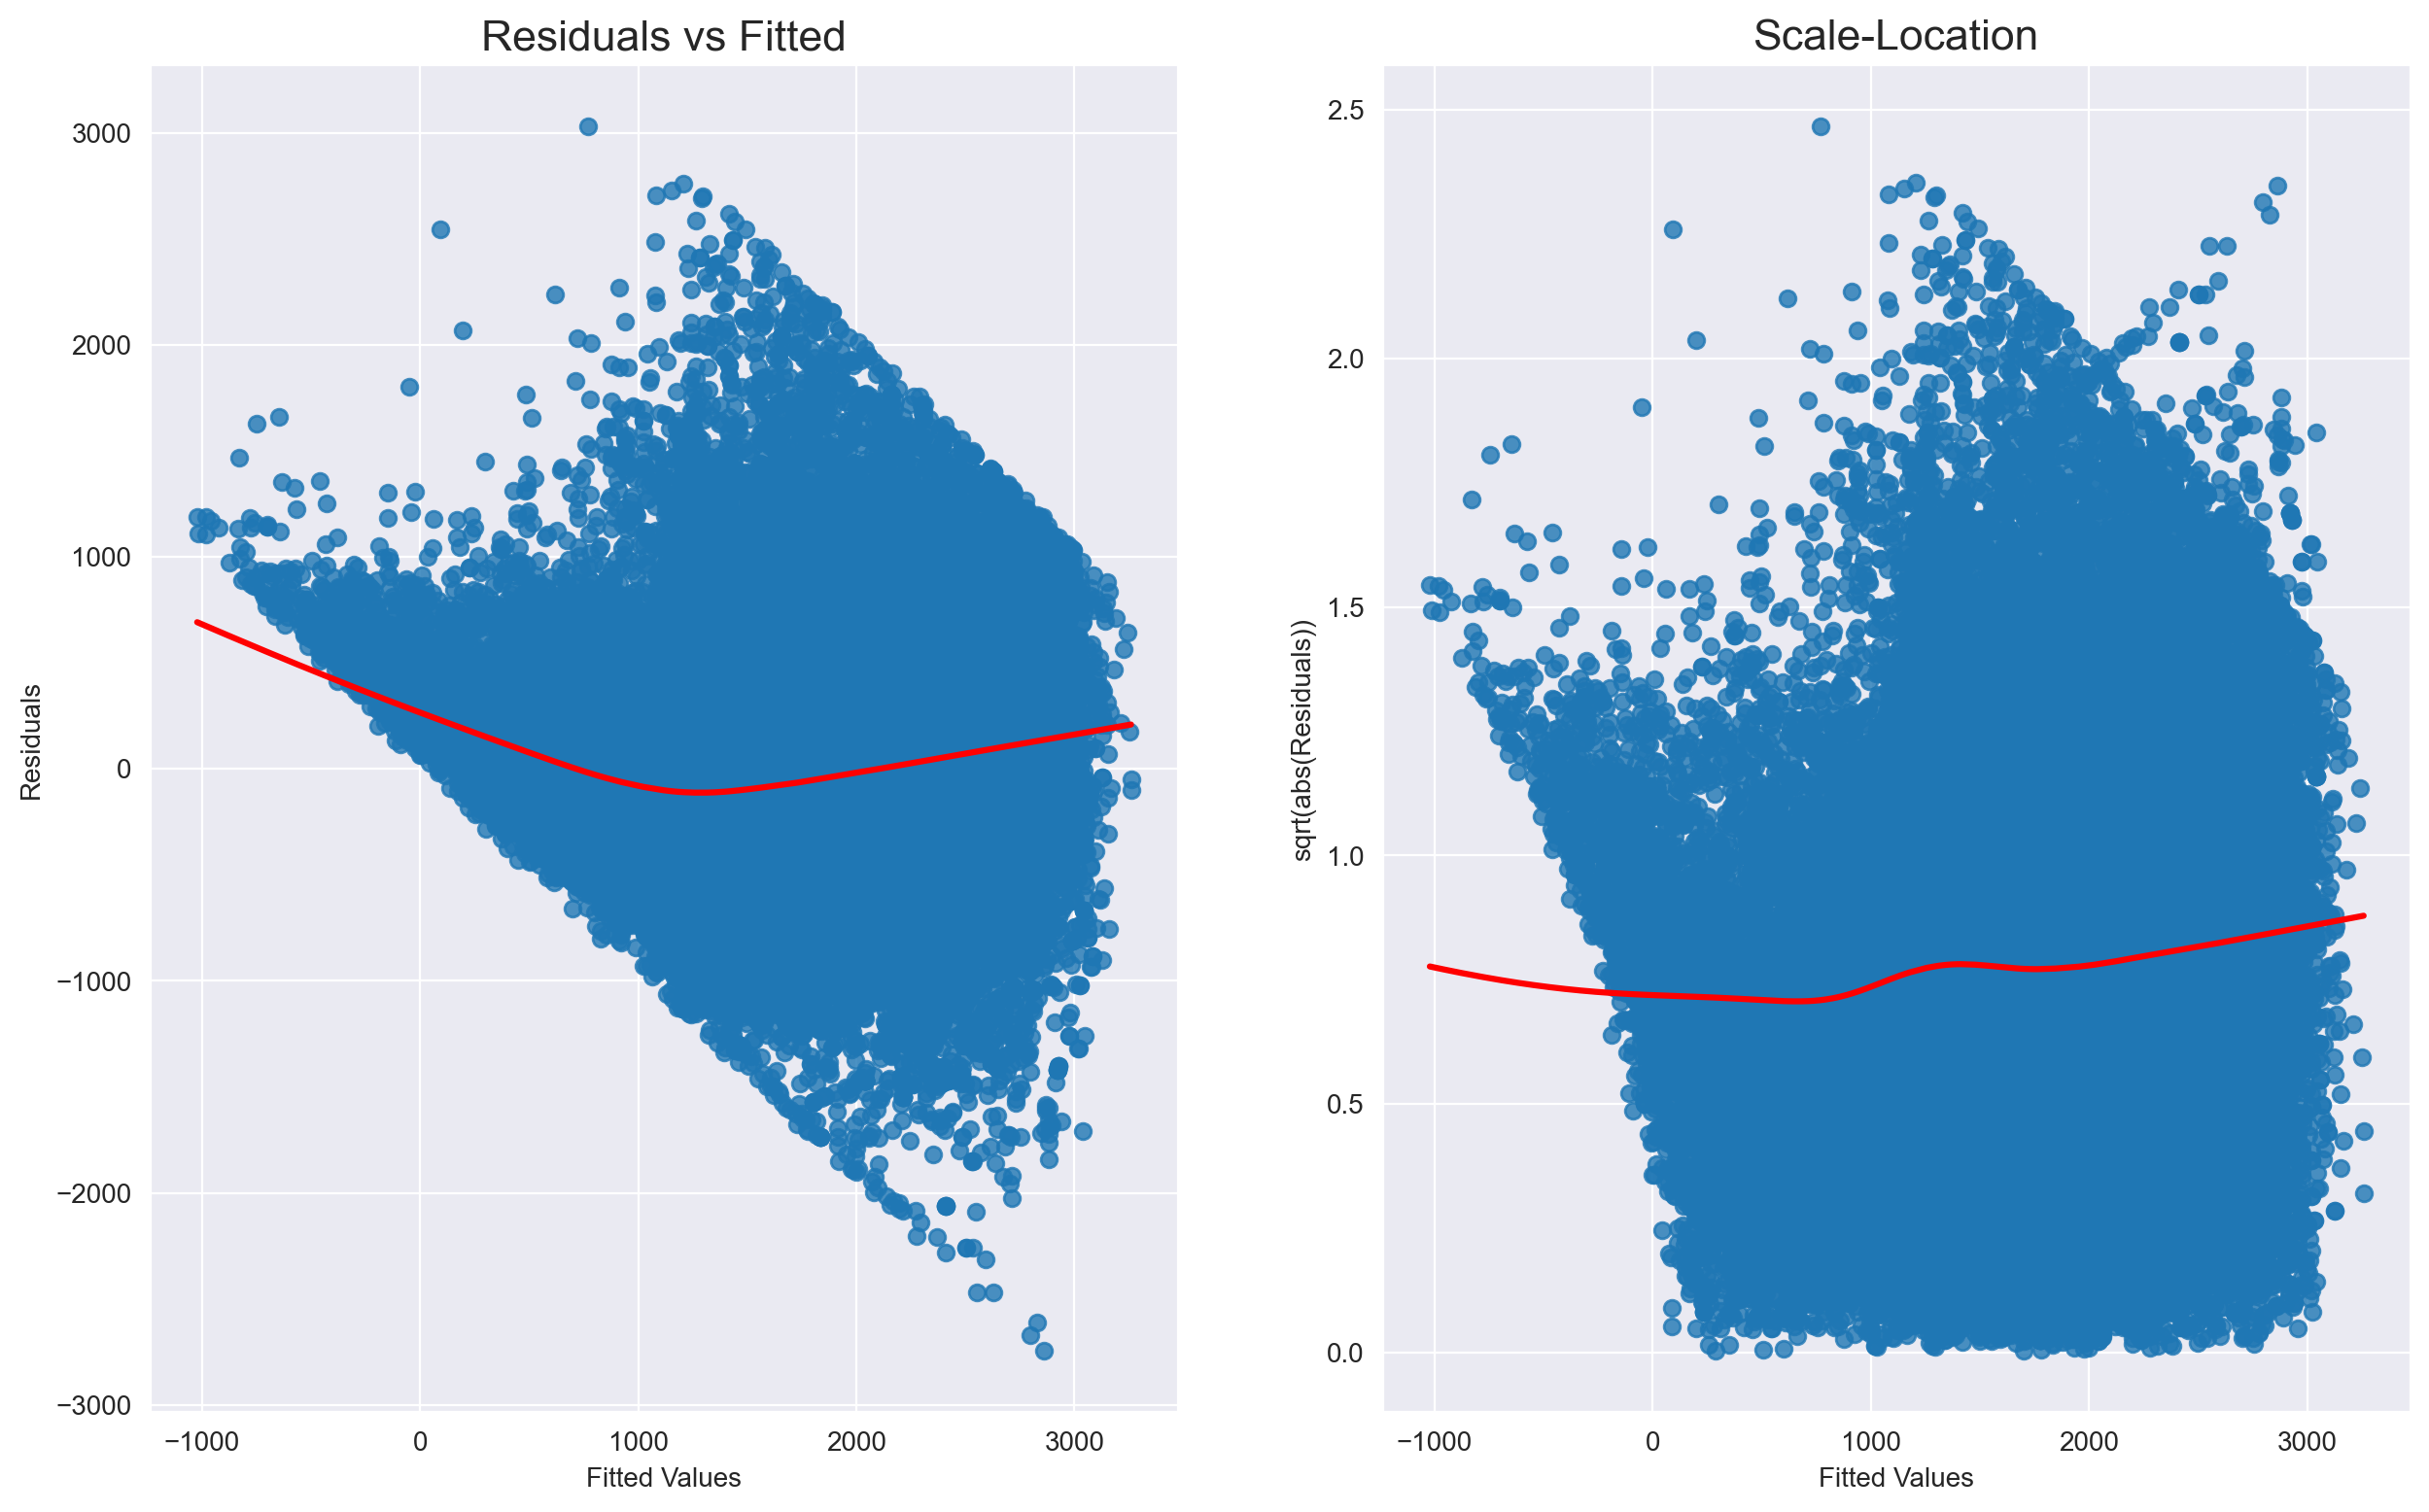

In [30]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    import numpy as np
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')

homoscedasticity_test(linereg_sm)

##### Autocorrelación

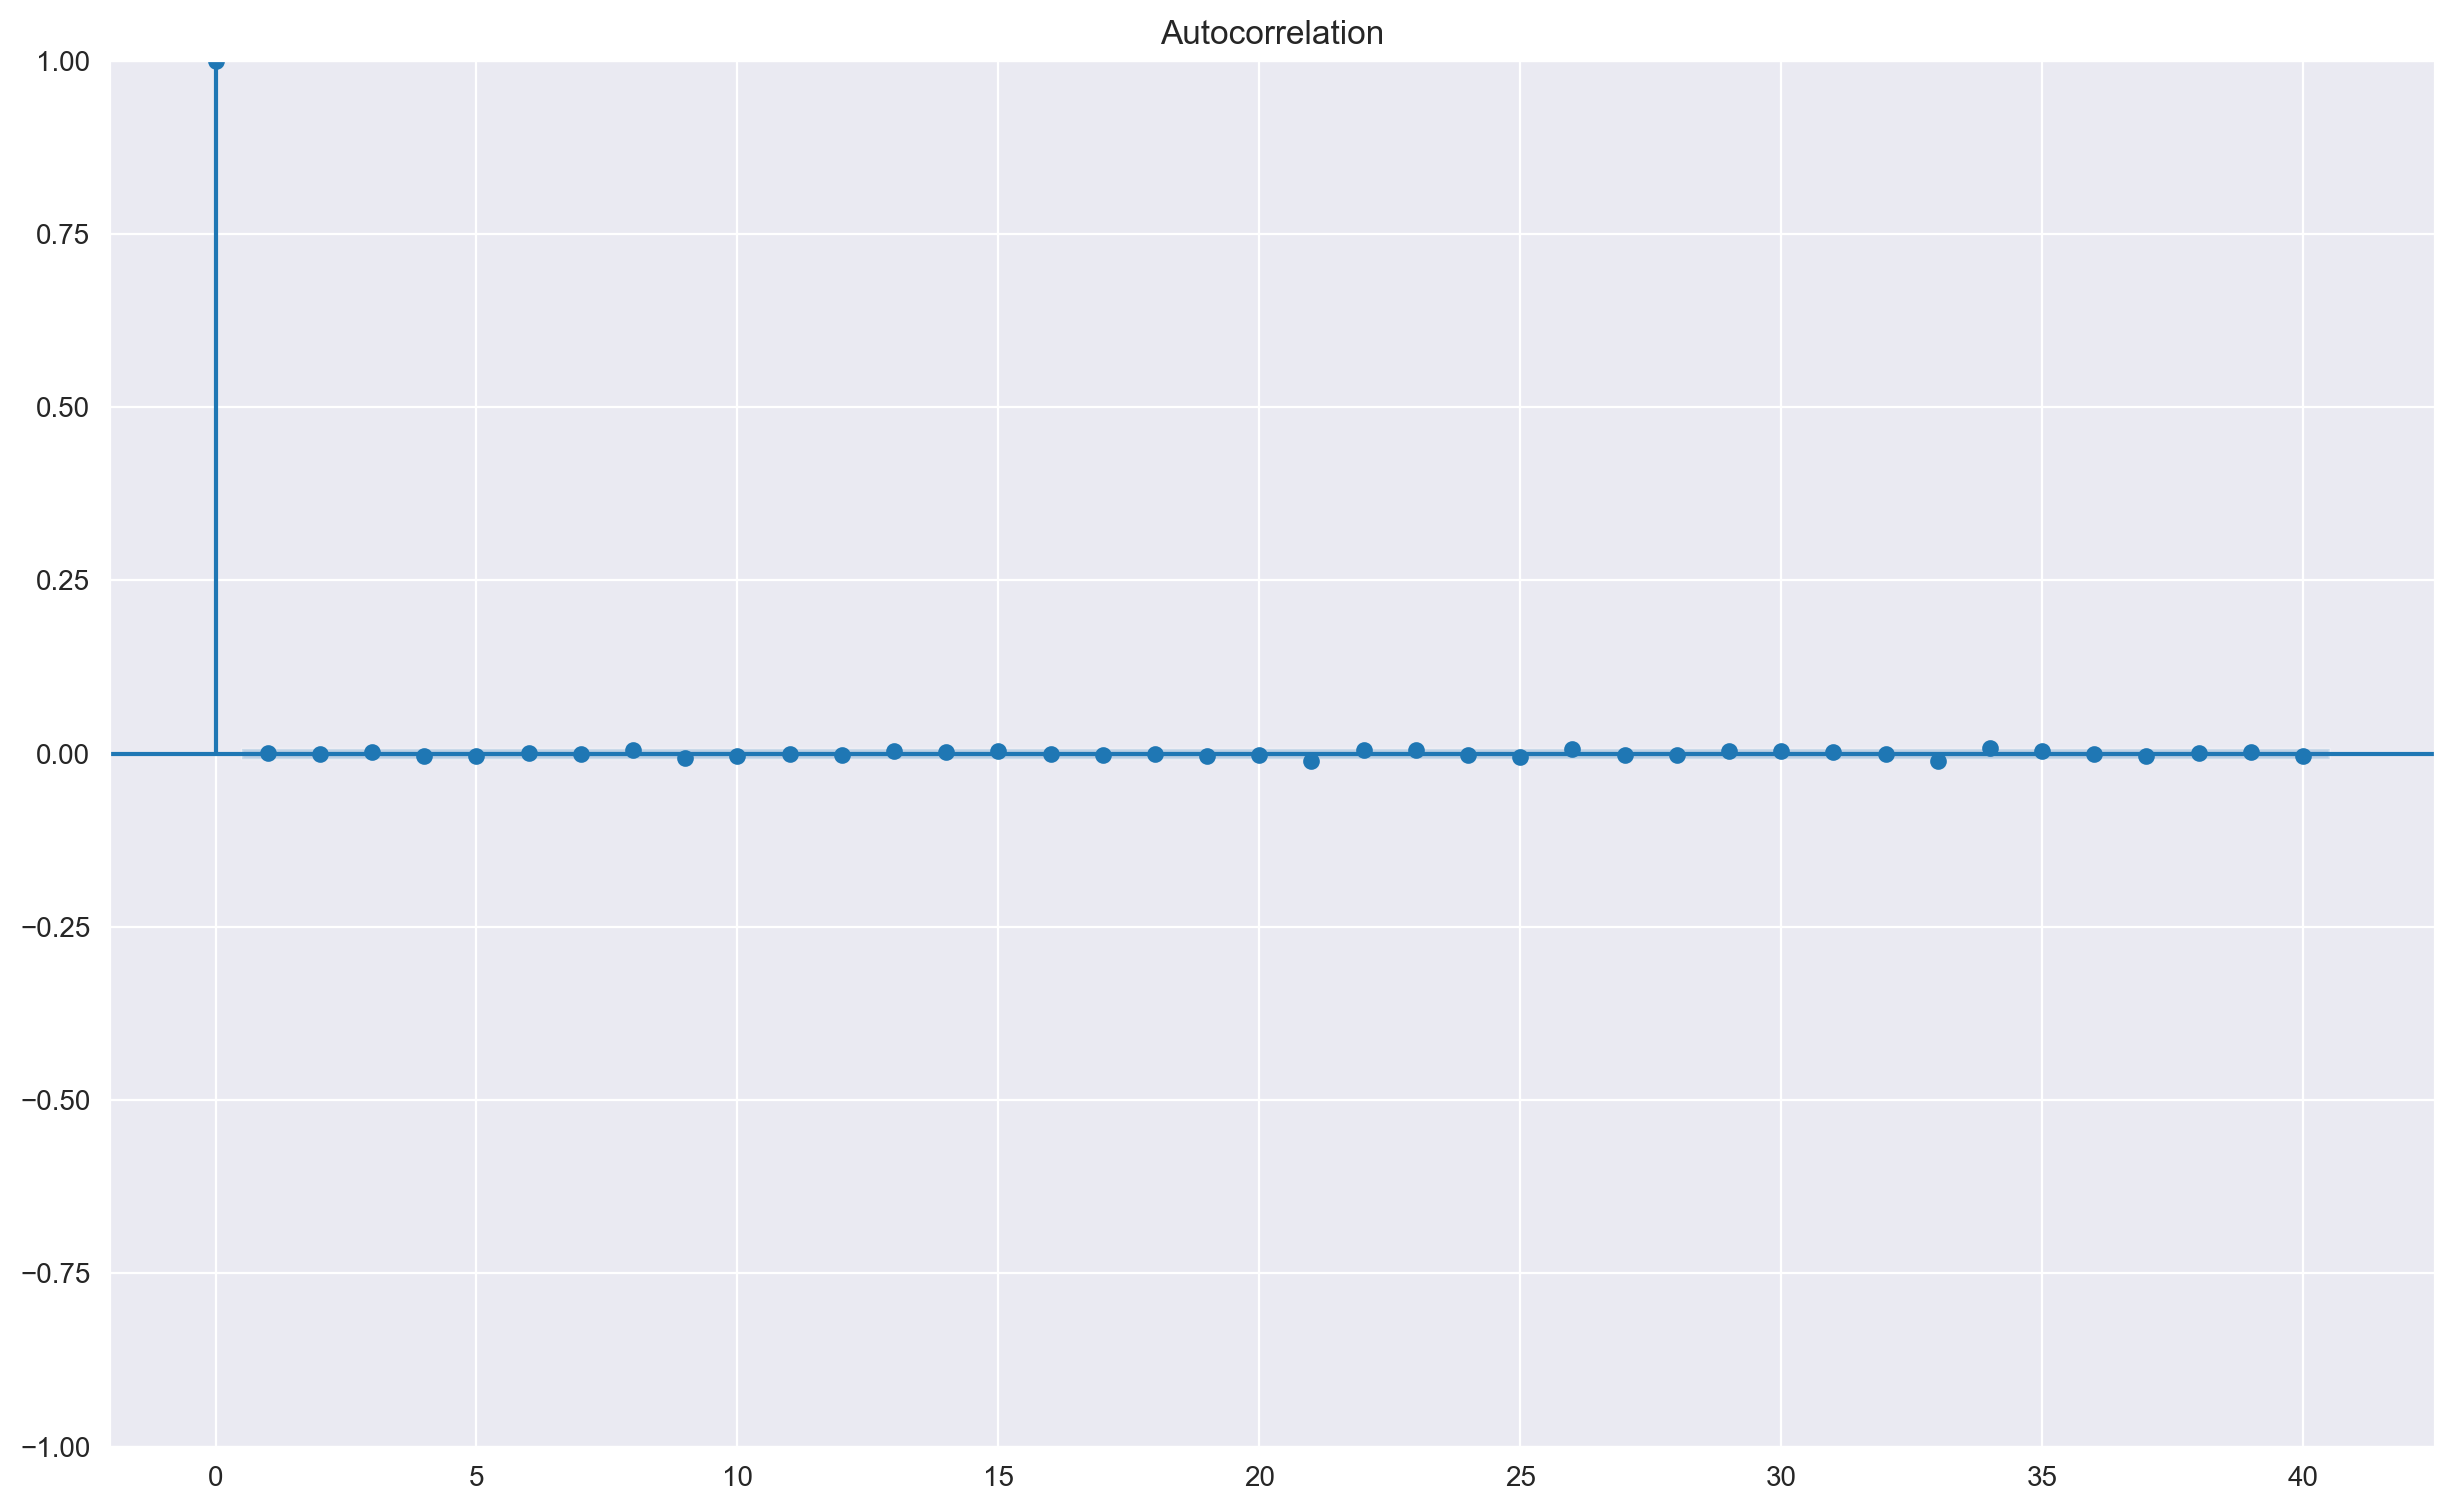

In [31]:
import statsmodels.tsa.api as smt

acf = smt.graphics.plot_acf(linereg_sm.resid, lags=40, alpha=0.05)

C:\Users\Joaquin\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Jarque-Bera test ---- statistic: 9030.0398, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.9821, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.5246, p-value: 0.0000
Anderson-Darling test ---- statistic: 257.7310, 5% critical value: 0.7870
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


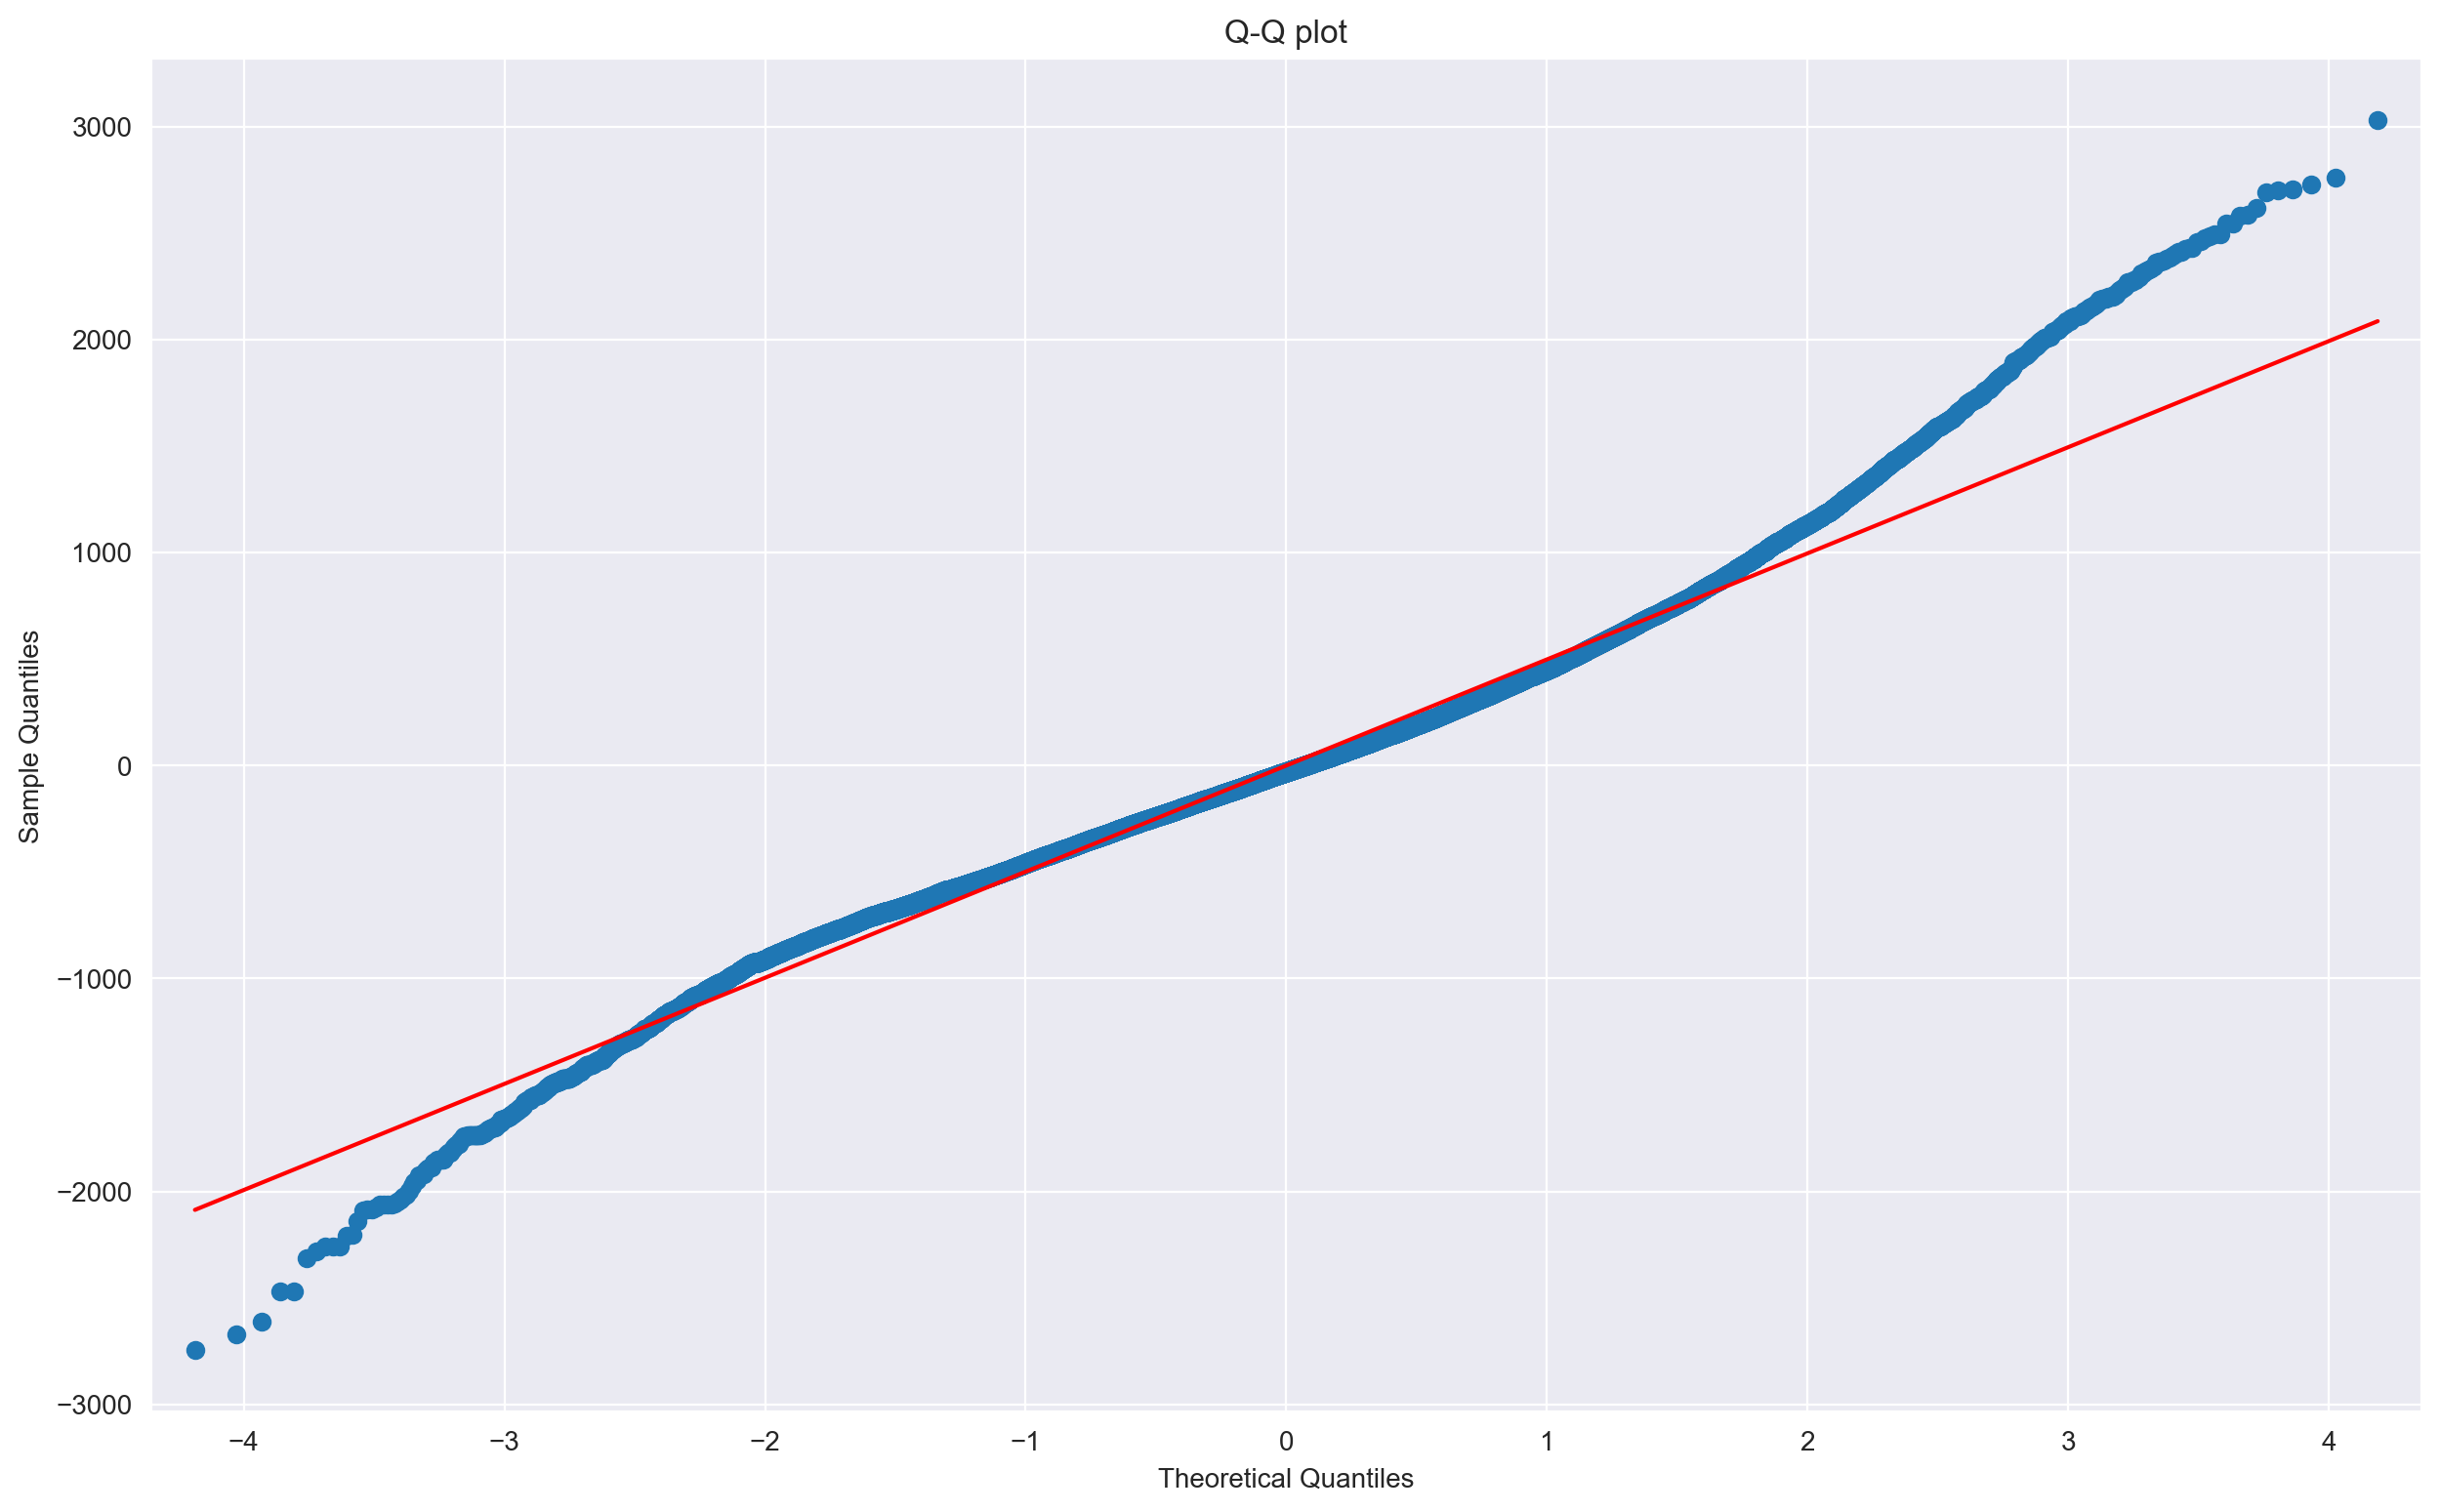

In [32]:
from scipy import stats

def normality_of_residuals_test(model):
    '''
    Function for drawing the normal QQ-plot of the residuals and running 4 statistical tests to 
    investigate the normality of residuals.
    
    Arg:
    * model - fitted OLS models from statsmodels
    '''
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')
    
normality_of_residuals_test(linereg_sm)